# Copulas and extreme events

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import norm
import matplotlib.pyplot as plt
from copulae import GaussianCopula

import warnings; warnings.filterwarnings('ignore')

In [5]:
# Define the portfolio
portfolio_tickers = ["MSFT", "AAPL", "GOOGL"]

# 1. Fetch real data
end_date = "2022-01-01"
start_date = "2020-01-01"
symbols = ["^GSPC"] + portfolio_tickers
data = yf.download(symbols, start=start_date, end=end_date, proxy="http://10.0.5.8:30890")["Adj Close"]
market_drop_percentage = -0.05

print("Downloaded:", data.head)

# 2. Compute daily returns
returns = data.pct_change().dropna()

# 3. Transform returns to [0,1] range using quantile transformation
quantile_transformers = {}
data_uniform = pd.DataFrame()

for symbol in returns.columns:
    qt = QuantileTransformer(output_distribution='uniform')
    data_uniform[symbol] = qt.fit_transform(returns[[symbol]]).flatten()
    quantile_transformers[symbol] = qt

# Define the function for conditional sampling
#
# the conditional_sample function generates n_samples from a conditional normal distribution with correlation 
# coefficient rho given u1 samples from the first normal distribution. It achieves this by calculating the 
# standardized difference between the scaled quantiles of the second normal distribution and the original 
# quantiles of the first normal distribution and then using the CDF of the standard normal distribution 
# to obtain the final samples.
#
# rho: the correlation coefficient between the two normal distributions
def conditional_sample(u1, rho, n_samples=1000):
    u2 = np.linspace(0.001, 0.999, n_samples)
    # 
    #                   /-> calculates the standardized difference between the scaled quantiles and original quantiles.
    # 
    return u2, norm.cdf((norm.ppf(u1) - rho * norm.ppf(u2)) / np.sqrt(1 - rho**2))

# Simulation for each stock in the portfolio
results = {}
for ticker in portfolio_tickers:
    index_drop = quantile_transformers["^GSPC"].transform(np.array([[market_drop_percentage]]))[0][0]
    
    # Bivariate assumption with ^GSPC and each stock
    bi_data = data_uniform[["^GSPC", ticker]]
    bi_copula = GaussianCopula(dim=2)
    bi_copula.fit(bi_data.values)
    rho = bi_copula.params[0]
    
    conditional_u2, conditional_cdf = conditional_sample(index_drop, rho)
    conditional_returns = quantile_transformers[ticker].inverse_transform(conditional_cdf.reshape(-1, 1)).flatten()
    results[ticker] = conditional_returns


[*********************100%***********************]  4 of 4 completed
Downloaded: <bound method NDFrame.head of                   AAPL       GOOGL        MSFT        ^GSPC
Date                                                       
2020-01-02   73.152649   68.433998  154.779510  3257.850098
2020-01-03   72.441475   68.075996  152.852249  3234.850098
2020-01-06   73.018684   69.890503  153.247330  3246.280029
2020-01-07   72.675262   69.755501  151.850067  3237.179932
2020-01-08   73.844345   70.251999  154.268799  3253.050049
...                ...         ...         ...          ...
2021-12-27  178.292877  147.906494  336.289185  4791.189941
2021-12-28  177.264618  146.686996  335.110718  4786.350098
2021-12-29  177.353622  146.654999  335.798126  4793.060059
2021-12-30  176.186935  146.200500  333.215454  4778.729980
2021-12-31  175.564056  144.852005  330.269379  4766.180176

[505 rows x 4 columns]>


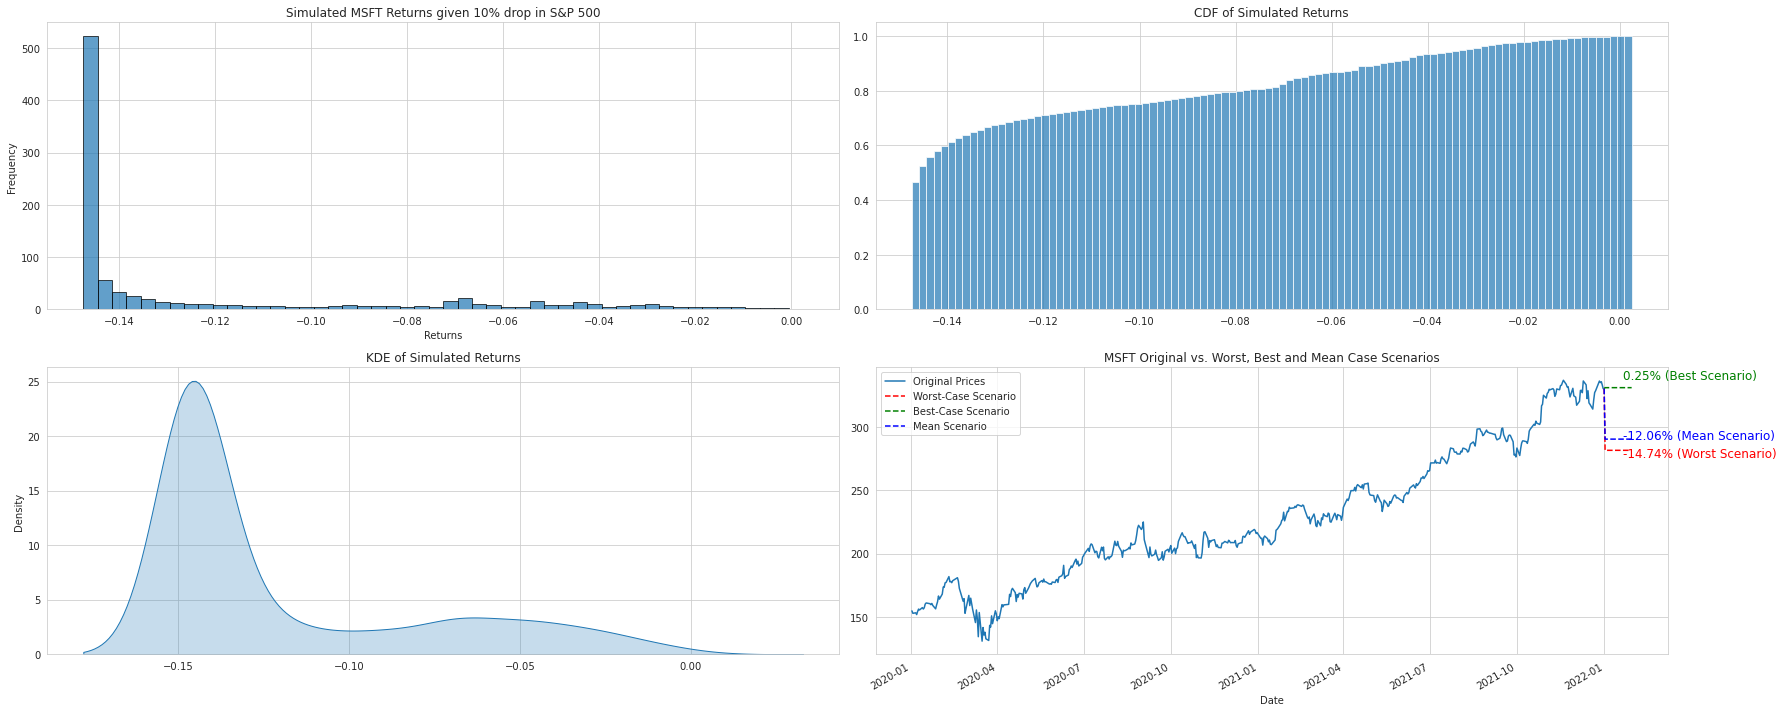

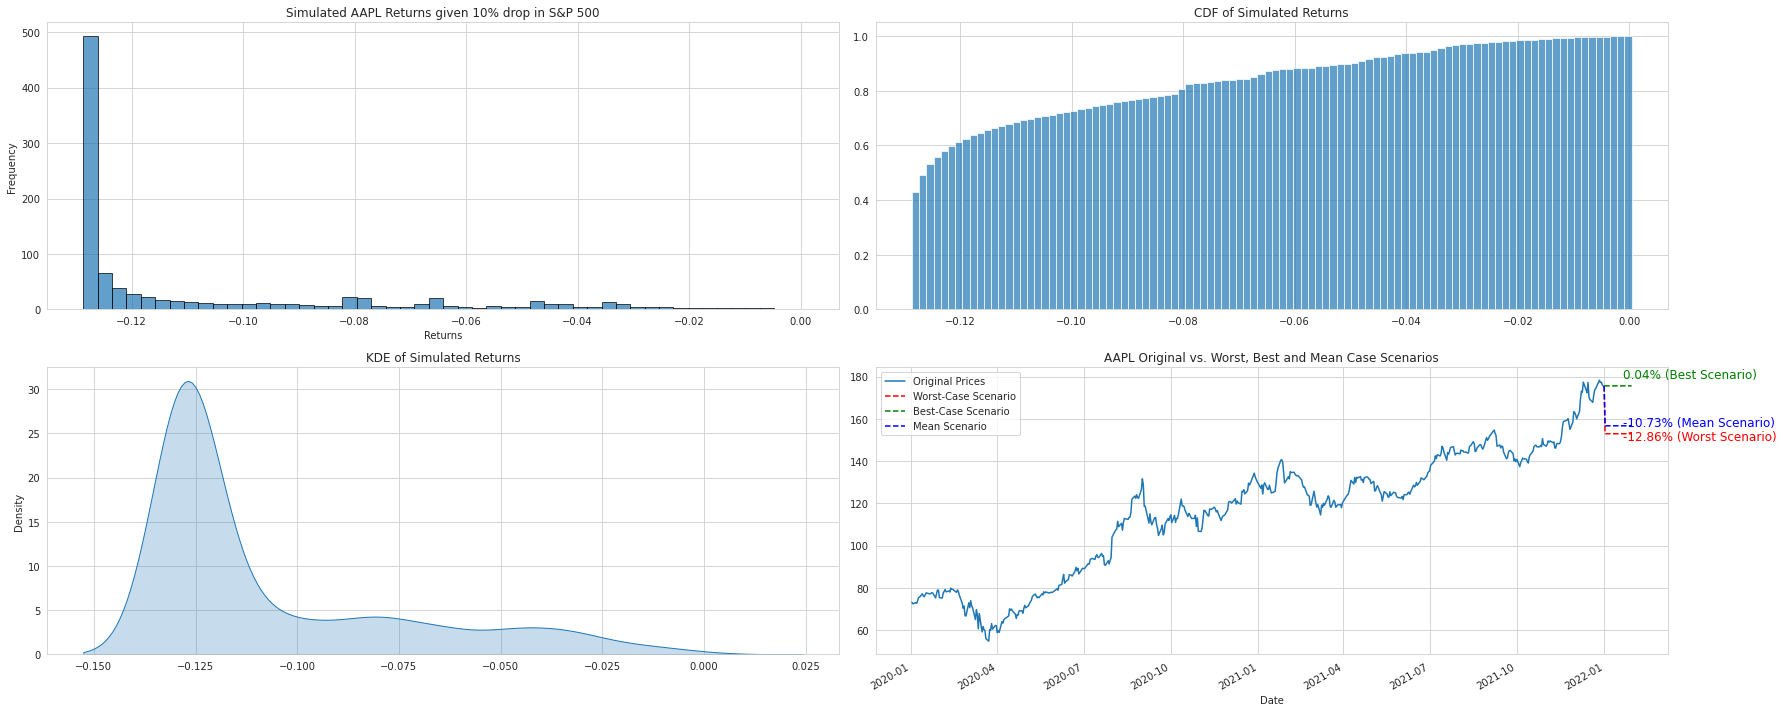

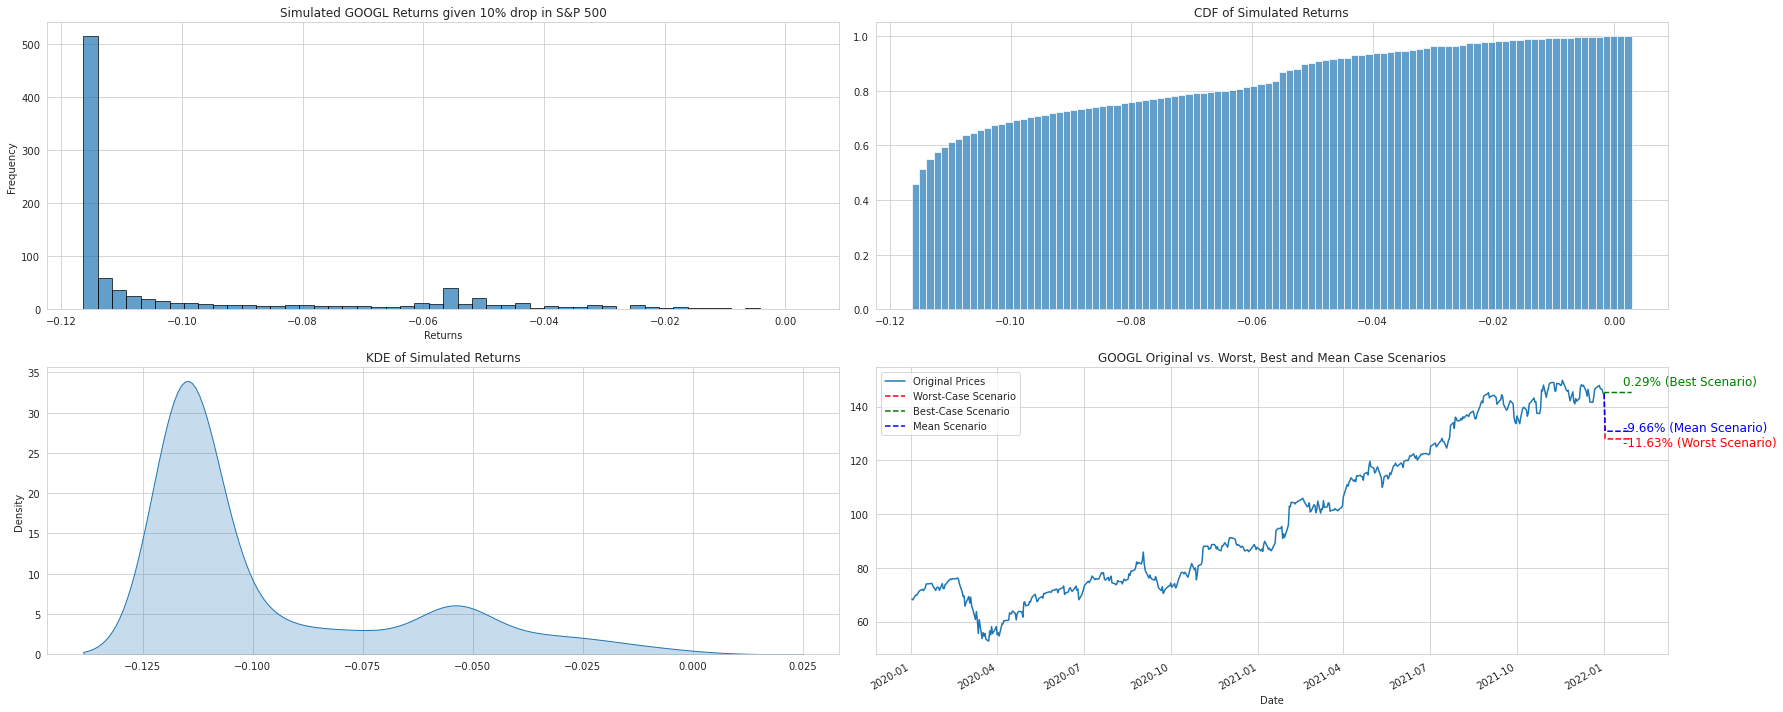

In [6]:

# Visualization for each stock in the portfolio
# Comment it out to see the impact to each stock in portfolio
for ticker, conditional_returns in results.items():
    fig, ax = plt.subplots(2, 2, figsize=(25, 10))
    last_known_price = data[ticker].iloc[-1]
    min_return = np.min(conditional_returns)
    max_return = np.max(conditional_returns)
    mean_return = np.mean(conditional_returns)

    final_min_price = last_known_price * (1 + min_return)
    final_max_price = last_known_price * (1 + max_return)
    final_mean_price = last_known_price * (1 + mean_return)

    simulated_dates = pd.date_range(start=data.index[-1], periods=31, freq='D')[1:]

    min_price_trajectory = [last_known_price] + [final_min_price] * (len(simulated_dates) - 1)
    max_price_trajectory = [last_known_price] + [final_max_price] * (len(simulated_dates) - 1)
    mean_price_trajectory = [last_known_price] + [final_mean_price] * (len(simulated_dates) - 1)

    # Plot 1: Histogram of Simulated Returns
    ax[0, 0].hist(conditional_returns, bins=50, edgecolor='k', alpha=0.7)
    ax[0, 0].set_title(f"Simulated {ticker} Returns given 10% drop in S&P 500")
    ax[0, 0].set_xlabel("Returns")
    ax[0, 0].set_ylabel("Frequency")

    # Plot 2: CDF of Simulated Returns
    ax[0, 1].hist(conditional_returns, bins=100, density=True, cumulative=True, alpha=0.7)
    ax[0, 1].set_title('CDF of Simulated Returns')

    # Plot 3: KDE of Simulated Returns
    sns.kdeplot(conditional_returns, shade=True, ax=ax[1, 0])
    ax[1, 0].set_title('KDE of Simulated Returns')

    # Plot 4: Ticker Original vs. Worst, Best, and Mean Case Scenarios
    data[ticker].plot(ax=ax[1, 1], label="Original Prices")
    pd.Series(min_price_trajectory, index=simulated_dates).plot(ax=ax[1, 1], label="Worst-Case Scenario", linestyle='--', color="red")
    pd.Series(max_price_trajectory, index=simulated_dates).plot(ax=ax[1, 1], label="Best-Case Scenario", linestyle='--', color="green")
    pd.Series(mean_price_trajectory, index=simulated_dates).plot(ax=ax[1, 1], label="Mean Scenario", linestyle='--', color="blue")

    label_x_position = simulated_dates[-10]
    ax[1, 1].annotate(f"{min_return*100:.2f}% (Worst Scenario)", (label_x_position, final_min_price * 0.98), fontsize=12, ha="left", color="red")
    ax[1, 1].annotate(f"{max_return*100:.2f}% (Best Scenario)", (label_x_position, final_max_price * 1.02), fontsize=12, ha="left", color="green")
    ax[1, 1].annotate(f"{mean_return*100:.2f}% (Mean Scenario)", (label_x_position, final_mean_price), fontsize=12, ha="left", color="blue")

    ax[1, 1].set_title(f"{ticker} Original vs. Worst, Best and Mean Case Scenarios")
    ax[1, 1].legend()

    plt.tight_layout()
    plt.show()


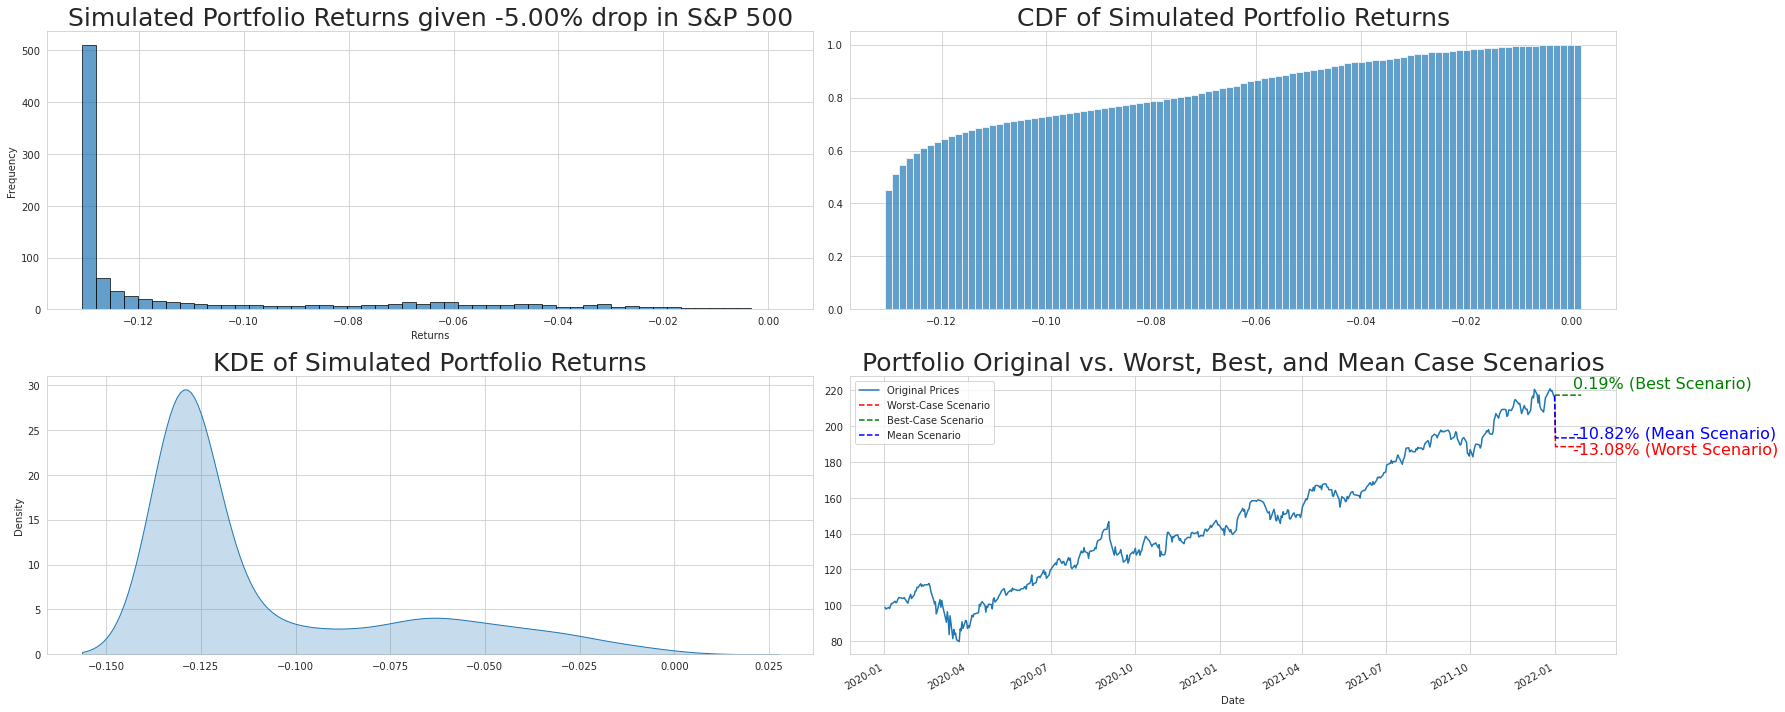

In [7]:

#  Compute portfolio returns from individual stock returns
portfolio_returns = np.mean(np.array([results[ticker] for ticker in portfolio_tickers]), axis=0)

# Visualization for the Portfolio
fig, ax = plt.subplots(2, 2, figsize=(25, 10))
last_known_prices = data[portfolio_tickers].iloc[-1]
portfolio_last_known_price = np.mean(last_known_prices)  # Equally weighted

min_return = np.min(portfolio_returns)
max_return = np.max(portfolio_returns)
mean_return = np.mean(portfolio_returns)

final_min_price = portfolio_last_known_price * (1 + min_return)
final_max_price = portfolio_last_known_price * (1 + max_return)
final_mean_price = portfolio_last_known_price * (1 + mean_return)

simulated_dates = pd.date_range(start=data.index[-1], periods=31, freq='D')[1:]

min_price_trajectory = [portfolio_last_known_price] + [final_min_price] * (len(simulated_dates) - 1)
max_price_trajectory = [portfolio_last_known_price] + [final_max_price] * (len(simulated_dates) - 1)
mean_price_trajectory = [portfolio_last_known_price] + [final_mean_price] * (len(simulated_dates) - 1)

# Plot 1: Histogram of Simulated Returns
ax[0, 0].hist(portfolio_returns, bins=50, edgecolor='k', alpha=0.7)
ax[0, 0].set_title(f"Simulated Portfolio Returns given {market_drop_percentage*100:.2f}% drop in S&P 500", fontsize=25)
ax[0, 0].set_xlabel("Returns")
ax[0, 0].set_ylabel("Frequency")

# Plot 2: CDF of Simulated Returns
ax[0, 1].hist(portfolio_returns, bins=100, density=True, cumulative=True, alpha=0.7)
ax[0, 1].set_title('CDF of Simulated Portfolio Returns', fontsize=25)

# Plot 3: KDE of Simulated Returns
sns.kdeplot(portfolio_returns, shade=True, ax=ax[1, 0])
ax[1, 0].set_title('KDE of Simulated Portfolio Returns', fontsize=25)

# Plot 4: Portfolio Original vs. Worst, Best, and Mean Case Scenarios
portfolio_prices = data[portfolio_tickers].mean(axis=1)
portfolio_prices.plot(ax=ax[1, 1], label="Original Prices")
pd.Series(min_price_trajectory, index=simulated_dates).plot(ax=ax[1, 1], label="Worst-Case Scenario", linestyle='--', color="red")
pd.Series(max_price_trajectory, index=simulated_dates).plot(ax=ax[1, 1], label="Best-Case Scenario", linestyle='--', color="green")
pd.Series(mean_price_trajectory, index=simulated_dates).plot(ax=ax[1, 1], label="Mean Scenario", linestyle='--', color="blue")

label_x_position = simulated_dates[-10]
ax[1, 1].annotate(f"{min_return*100:.2f}% (Worst Scenario)", (label_x_position, final_min_price * 0.98), fontsize=16, ha="left", color="red")
ax[1, 1].annotate(f"{max_return*100:.2f}% (Best Scenario)", (label_x_position, final_max_price * 1.02), fontsize=16, ha="left", color="green")
ax[1, 1].annotate(f"{mean_return*100:.2f}% (Mean Scenario)", (label_x_position, final_mean_price), fontsize=16, ha="left", color="blue")

ax[1, 1].set_title(f"Portfolio Original vs. Worst, Best, and Mean Case Scenarios", fontsize=25)
ax[1, 1].legend()

# General configurations for the plot aesthetics
sns.set_style("whitegrid")
plt.tight_layout()
plt.show()

# Tail dependence with Copula

[*********************100%***********************]  6 of 6 completed


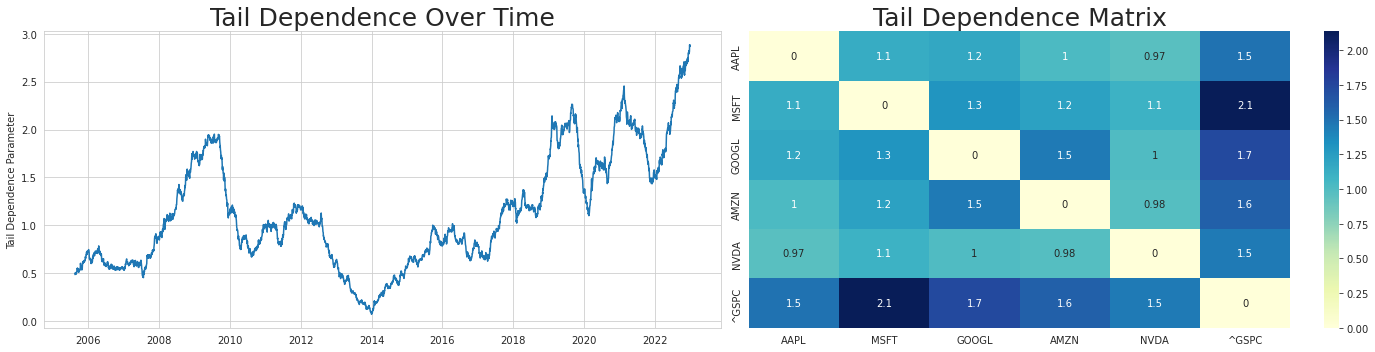

In [9]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
from scipy.stats import rankdata
from copulas.bivariate import Clayton
import warnings; warnings.filterwarnings('ignore')

# 1. Data Collection:
# Definestock basket
stocks = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "^GSPC"]
# Fetch data
data = yf.download(stocks, start="2000-01-01", end="2023-01-01", proxy="http://10.0.5.8:30890")['Adj Close']

# 2. Data Preprocessing:
# Compute daily returns and drop NaN values
returns = data.pct_change().dropna()

# Convert data to uniform using ECDF
def to_uniform(column):
    n = len(column)
    return rankdata(column) / (n + 1)

uniform_data = returns.apply(to_uniform)

# 3. Rolling Time Window Analysis:
# Rolling window analysis
window_size = 250
tail_parameters = []

for start in range(0, len(uniform_data) - window_size):
    window_data = uniform_data.iloc[start:start + window_size]
    
    copula = Clayton()
    copula.fit(window_data.values)
    
     # Extract tail parameter (for Clayton, the theta parameter)
    tail_parameters.append(copula.theta)

# 4. Visualization:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))  # 1 row, 2 columns

# Plotting the Tail Dependence Over Time on the first subplot
ax1.plot(returns.index[window_size:], tail_parameters)
ax1.set_title('Tail Dependence Over Time',fontsize=25)
ax1.set_ylabel('Tail Dependence Parameter')

# Constructing the Tail Dependence Matrix
tail_dep_matrix = np.zeros((len(stocks), len(stocks)))
for i in range(len(stocks)):
    for j in range(len(stocks)):
        if i != j:
            copula_ij = Clayton()
            copula_ij.fit(uniform_data[[stocks[i], stocks[j]]].values)
            tail_dep_matrix[i, j] = copula_ij.theta

# Plotting the heatmap on the second subplot
sns.heatmap(tail_dep_matrix, annot=True, cmap='YlGnBu', xticklabels=stocks, yticklabels=stocks, ax=ax2)
ax2.set_title("Tail Dependence Matrix", fontsize=25)

plt.tight_layout()  
plt.show()

QuantileTransformer.transform / inverse_transform / fit_transform

* https://stats.stackexchange.com/questions/325570/quantile-transformation-with-gaussian-distribution-sklearn-implementation


https://ww2.mathworks.cn/help/econ/using-extreme-value-theory-and-copulas-to-evaluate-market-risk.html